In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import openpyxl

plt.style.use(["bmh"])

file_name = "./tests/@CN_OGX-101.xlsx"

dataframe = pd.read_excel(
    file_name,
    skiprows=0,
    decimal=",",
    sheet_name="LONGÁ",
)

dataframe

,Profundidade,TVDSS,Remessa,TN%,d15N,TOC%,d13C,TOC/TN,TS%,TC%,TIC%,Rut
0,1602,-1481,PlacaSolosB3,NaN,NaN,0.748032,-28.039595,NaN,0.6260,0.865,0.116968,TS+TC_1
1,1605,-1484,NaN,NaN,NaN,0.727188,-27.861636,NaN,0.5200,1.220,0.492812,NaN
2,1608,-1487,NaN,0.029141,-3.275129,1.021515,-28.087772,35.054467,0.1570,1.000,0.000000,NaN
3,1611,-1490,NaN,0.051952,-1.658432,1.749124,-27.963889,33.667890,0.2510,1.330,0.000000,NaN
4,1614,-1493,NaN,NaN,NaN,0.920391,-27.979620,NaN,0.1830,1.060,0.139610,NaN
5,1617,-1496,NaN,0.032208,-3.347971,1.125040,-28.175277,34.931007,0.1630,1.250,0.124960,NaN
6,1620,-1499,NaN,0.035777,-1.901240,1.179407,-28.013049,32.965606,0.5620,1.490,0.310593,NaN
7,1623,-1502,NaN,0.027977,NaN,0.902029,-27.662046,32.241442,0.2300,1.110,0.207972,NaN
8,1626,-1505,NaN,0.033763,-0.740820,1.056206,-27.335624,31.282653,0.3410,1.360,0.303794,NaN
9,1629,-1508,NaN,0.035242,-0.500036,1.355276,-27.668929,38.455935,0.2300,1.610,0.254724,NaN


In [80]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Dados dos pontos-chave de probabilidade do
TOC_TN_ARTIGO = np.array(
    [4, 4, 4, 4, 10, 10, 10, 10, 100, 100, 100, 100]
)  # Lista/array dos valores de TOC:TN dos pontos-chave
C13CORG_ARTIGO = np.array(
    [-10, -22, -25, -34, -10, -22, -25, -34, -10, -22, -25, -34]
)  # Lista/array dos valores de δ13Corg dos pontos-chave
D15N_ARTIGO = np.array(
    [12, 3, 0, -12, 12, 3, 0, -12, 12, 3, 0, -12]  # MUDAR
)  # Lista/array dos valores do terceiro variável

PROBABILIDADE = np.array(
    [0, 10, 20, 30, 20, 30, 40, 50, 90, 95, 98, 100]
)  # Lista/array dos valores de probabilidade dos pontos-chave

# Dados das suas amostras
amostra_TOC_TN = dataframe[
    "TOC/TN"
].values  # Lista/array dos valores de TOC:TN das suas amostras
amostra_C13CORG = dataframe[
    "d13C"
].values  # Lista/array dos valores de δ13Corg das suas amostras
amostra_D15N = dataframe["d15N"].values  # Lista/array dos valores do terceiro variável

# Sample data
X = np.column_stack((TOC_TN_ARTIGO, C13CORG_ARTIGO, D15N_ARTIGO))
y = PROBABILIDADE

# Define the kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# Create the Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Fit to the data
gp.fit(X, y)

# Predict on new data
X_new = np.column_stack((amostra_TOC_TN, amostra_C13CORG, amostra_D15N))

# Handle NaN values by imputing them
imputer = SimpleImputer(strategy="mean")
X_new_imputed = imputer.fit_transform(X_new)

# Predict with the imputed data
y_pred, sigma = gp.predict(X_new_imputed, return_std=True)

amostra = 100 - y_pred

print(y_pred)
print(amostra)

[49.41979821 49.36569932 43.9304767  46.01842706 49.40187693 44.28879078
 47.81428563 48.37050893 50.13084529 34.27610293 53.08124673 47.80342449
 49.5195305  55.72455989 54.65916308 48.1350158  36.50377761 54.33768847
 47.53140982 48.60398635 62.89177578]
[50.58020179 50.63430068 56.0695233  53.98157294 50.59812307 55.71120922
 52.18571437 51.62949107 49.86915471 65.72389707 46.91875327 52.19657551
 50.4804695  44.27544011 45.34083692 51.8649842  63.49622239 45.66231153
 52.46859018 51.39601365 37.10822422]


c:\Users\aalbano\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [57]:
# USANDO O MÉTODO ANTIGO
from pykrige.ok import OrdinaryKriging

# Grade de valores para interpolação
art_toc_tn_grid = np.linspace(0, 100, 1001)  # Valores de TOC:TN para a grade
art_c13corg_grid = np.linspace(-34, -10, 241)  # Valores de δ13Corg para a grade

# Kriging
OK = OrdinaryKriging(
    TOC_TN_ARTIGO,
    C13CORG_ARTIGO,
    PROBABILIDADE,
    variogram_model="gaussian",
)
z, ss = OK.execute("grid", art_toc_tn_grid, art_c13corg_grid)

# Aplicação dos dados das suas amostras na grade interpolada
amostra_probabilidade, ss = OK.execute("points", amostra_TOC_TN, amostra_C13CORG)

print(np.shape(z))
print(np.shape(amostra_probabilidade))

(241, 1001)
(21,)


In [ ]:
def foo(dataframe):
    dataframe["TOMI Index"] = amostra
    
    new_dataframe = pd.DataFrame(columns=dataframe.columns)

    for index, row in dataframe.iterrows():
        # Repeat each row three times
        for i in range(3):
            new_row = row.copy()
            new_row["Profundidade"] = row["Profundidade"] - 2 + i
            new_dataframe = pd.concat([new_dataframe, pd.DataFrame([new_row])], ignore_index=True)
        
    dataframe = new_dataframe
      
    return dataframe

In [79]:
dataframe["TOMI Index"] = amostra

new_dataframe = pd.DataFrame(columns=dataframe.columns)

# Iterate over each row in the original DataFrame
# Iterate over each row in the original DataFrame
for index, row in dataframe.iterrows():
    # Repeat each row three times
    for i in range(3):
        new_row = row.copy()
        new_row["Profundidade"] = row["Profundidade"] - 2 + i
        new_dataframe = pd.concat([new_dataframe, pd.DataFrame([new_row])], ignore_index=True)

# Display the new DataFrame
new_dataframe

C:\Users\aalbano\AppData\Local\Temp\ipykernel_16536\496336701.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_dataframe = pd.concat([new_dataframe, pd.DataFrame([new_row])], ignore_index=True)


,Profundidade,TVDSS,TN%,d15N,TOC%,d13C,TOC/TN,TS%,TC%,TIC%,Rut,TOMI Index
0,1600,-1481,NaN,NaN,0.748032,-28.039595,NaN,0.626,0.865,0.116968,TS+TC_1,50.580203
1,1601,-1481,NaN,NaN,0.748032,-28.039595,NaN,0.626,0.865,0.116968,TS+TC_1,50.580203
2,1602,-1481,NaN,NaN,0.748032,-28.039595,NaN,0.626,0.865,0.116968,TS+TC_1,50.580203
3,1603,-1484,NaN,NaN,0.727188,-27.861636,NaN,0.520,1.220,0.492812,NaN,50.634302
4,1604,-1484,NaN,NaN,0.727188,-27.861636,NaN,0.520,1.220,0.492812,NaN,50.634302
...,...,...,...,...,...,...,...,...,...,...,...,...
58,1661,-1541,0.040357,0.303254,1.273767,-27.861636,31.562414,0.371,1.400,0.126233,NaN,51.396015
59,1662,-1541,0.040357,0.303254,1.273767,-27.861636,31.562414,0.371,1.400,0.126233,NaN,51.396015
60,1663,-1544,0.076295,-1.234530,1.689473,-27.730870,22.143866,0.164,1.560,0.000000,NaN,37.108225
61,1664,-1544,0.076295,-1.234530,1.689473,-27.730870,22.143866,0.164,1.560,0.000000,NaN,37.108225


C:\Users\aalbano\AppData\Local\Temp\ipykernel_16536\1340688852.py:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "s-" (-> linestyle='-'). The keyword argument will take precedence.
  axes[0].plot(
C:\Users\aalbano\AppData\Local\Temp\ipykernel_16536\1340688852.py:19: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "s-" (-> linestyle='-'). The keyword argument will take precedence.
  axes[1].plot(
C:\Users\aalbano\AppData\Local\Temp\ipykernel_16536\1340688852.py:34: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "s-" (-> linestyle='-'). The keyword argument will take precedence.
  axes[2].plot(
C:\Users\aalbano\AppData\Local\Temp\ipykernel_16536\1340688852.py:48: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "s-" (-> linestyle='-'). The keyword argument will take precedenc

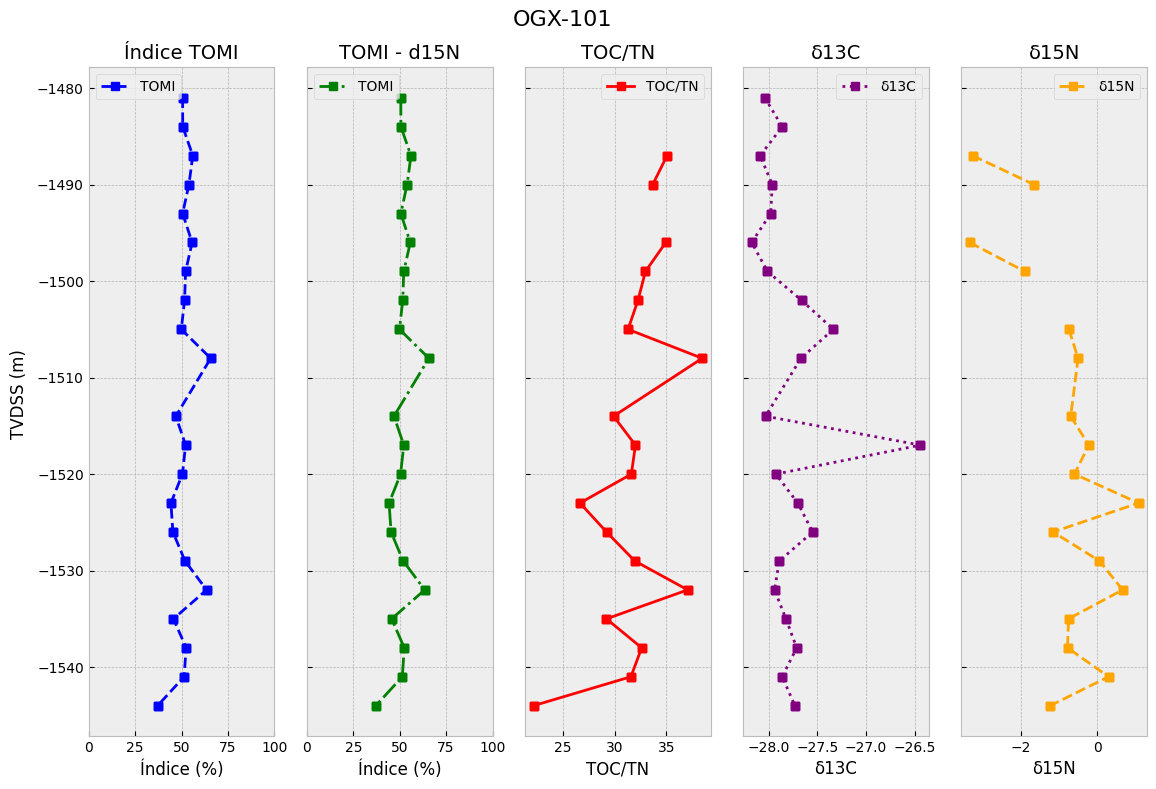

In [77]:
fig, axes = plt.subplots(1, 5, figsize=(12, 8), sharey=True)
fig.suptitle("OGX-101", fontsize=16)
# Personalização do primeiro gráfico
axes[0].plot(
    amostra_probabilidade,
    dataframe["TVDSS"],
    "s-",
    label="TOMI",
    color="blue",
    linestyle="--",
)
axes[0].set_xlim(0, 100)
axes[0].set_title("Índice TOMI", fontsize=14)
axes[0].set_xlabel("Índice (%)", fontsize=12)
axes[0].legend()
axes[0].grid(True)

# Personalização do segundo gráfico
axes[1].plot(
    amostra,
    dataframe["TVDSS"],
    "s-",
    label="TOMI",
    color="green",
    linestyle="-.",
)
axes[1].set_xlim(0, 100)
axes[1].set_title("TOMI - d15N", fontsize=14)
axes[1].set_xlabel("Índice (%)", fontsize=12)
axes[1].legend()
axes[1].grid(True)

# Personalização do terceiro gráfico
axes[2].plot(
    dataframe["TOC/TN"],
    dataframe["TVDSS"],
    "s-",
    label="TOC/TN",
    color="red",
    linestyle="-",
)
axes[2].set_title("TOC/TN", fontsize=14)
axes[2].set_xlabel("TOC/TN", fontsize=12)
axes[2].legend()
axes[2].grid(True)

# Personalização do quarto gráfico
axes[3].plot(
    dataframe["d13C"],
    dataframe["TVDSS"],
    "s-",
    label="δ13C",
    color="purple",
    linestyle=":",
)
axes[3].set_title("δ13C", fontsize=14)
axes[3].set_xlabel("δ13C", fontsize=12)
axes[3].legend()
axes[3].grid(True)

# Personalização do quinto gráfico
axes[4].plot(
    dataframe["d15N"],
    dataframe["TVDSS"],
    "s-",
    label="δ15N",
    color="orange",
    linestyle="--",
)
axes[4].set_title("δ15N", fontsize=14)
axes[4].set_xlabel("δ15N", fontsize=12)
axes[4].legend()
axes[4].grid(True)

# Configuração do rótulo comum do eixo y
fig.text(0.04, 0.5, "TVDSS (m)", va="center", rotation="vertical", fontsize=12)

# Ajuste do layout
plt.tight_layout(rect=[0.05, 0, 1, 1])
plt.show()